## Importing libraries

In [10]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import matplotlib.cm as cm

## Model Load And Checks

In [11]:
from tensorflow.keras.models import load_model
model = load_model("mobilenetv2_deepfake.h5",compile=False)
model.summary()
model.input_shape
model.output_shape


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

(None, 1)

## Layers in model

In [12]:
for i, layer in enumerate(model.layers):
    print(i, layer.name, type(layer))


0 mobilenetv2_1.00_128 <class 'keras.src.models.functional.Functional'>
1 global_average_pooling2d <class 'keras.src.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D'>
2 dense <class 'keras.src.layers.core.dense.Dense'>
3 dropout <class 'keras.src.layers.regularization.dropout.Dropout'>
4 dense_1 <class 'keras.src.layers.core.dense.Dense'>


## Image Preprocessing

In [13]:
def preprocess_img(img_path, size=(128, 128)):
    """Load and preprocess image for MobileNetV2"""
    img = image.load_img(img_path, target_size=size)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x, img

## Heat Map generation

In [14]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name="out_relu", pred_index=None):
    """
    Grad-CAM for Sequential model wrapping MobileNetV2.
    """
   
    base_model = model.layers[0]

    _ = model(img_array)

    conv_layer = base_model.get_layer(last_conv_layer_name)

    grad_model = tf.keras.models.Model(
        inputs=base_model.input,
        outputs=[conv_layer.output, base_model.output],
    )

    with tf.GradientTape() as tape:
        conv_outputs, base_features = grad_model(img_array)
        
        x = base_features
        for layer in model.layers[1:]:
            x = layer(x)
        predictions = x

        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    
    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)

    heatmap = np.maximum(heatmap, 0)
    if np.max(heatmap) != 0:
        heatmap /= np.max(heatmap)

    return heatmap, predictions


## Overlay function using Pillow + Matplotlib

In [15]:

def overlay_heatmap_pil(heatmap, original_img, alpha=0.4, colormap='jet'):
    """Overlay Grad-CAM heatmap on the original image"""
    heatmap = np.uint8(255 * heatmap)
    cmap = cm.get_cmap(colormap)
    heatmap_color = cmap(heatmap)
    heatmap_color = Image.fromarray((heatmap_color[:, :, :3] * 255).astype(np.uint8))
    heatmap_color = heatmap_color.resize(original_img.size)
    blended = Image.blend(original_img.convert("RGBA"), heatmap_color.convert("RGBA"), alpha)
    return blended


## Visualization runner

In [ ]:
def visualize_gradcam(img_path):
    """Run prediction + Grad-CAM and visualize results with color-coded title"""
    img_array, original_img = preprocess_img(img_path)
    heatmap, pred = make_gradcam_heatmap(img_array, model, "out_relu")

    
    result_img = overlay_heatmap_pil(heatmap, original_img)

   
    pred_value = float(pred[0][0])
    label = "Real" if pred_value > 0.5 else "Fake"
    confidence = round(pred_value * 100 if label == "Real" else (1 - pred_value) * 100, 2)

    if label == "Real":
        title_color = "green"
        label_text = f"🟢 Real Detected ({confidence}%)"
    else:
        title_color = "red"
        label_text = f"🔴 Fake Detected ({confidence}%)"

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    fig.patch.set_facecolor("#f4f4f4")

    
    ax1.imshow(original_img)
    ax1.set_title("Original Image", fontsize=13, fontweight='bold')
    ax1.axis("off")

    #Grad-CAM result 
    ax2.imshow(result_img)
    ax2.set_title(label_text, fontsize=13, fontweight='bold', color=title_color)
    ax2.axis("off")

    plt.tight_layout()
    plt.show()

    # Save result image
    #out_path = img_path.replace(".jpg", "_gradcam.jpg").replace(".png", "_gradcam.jpg")
    #result_img.save(out_path)
    #print(f"\n✅ {label_text} | Saved at: {out_path}")


C:\Users\ratan\AppData\Local\Temp\ipykernel_5088\886430562.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(colormap)
C:\Users\ratan\AppData\Local\Temp\ipykernel_5088\2842950448.py:36: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


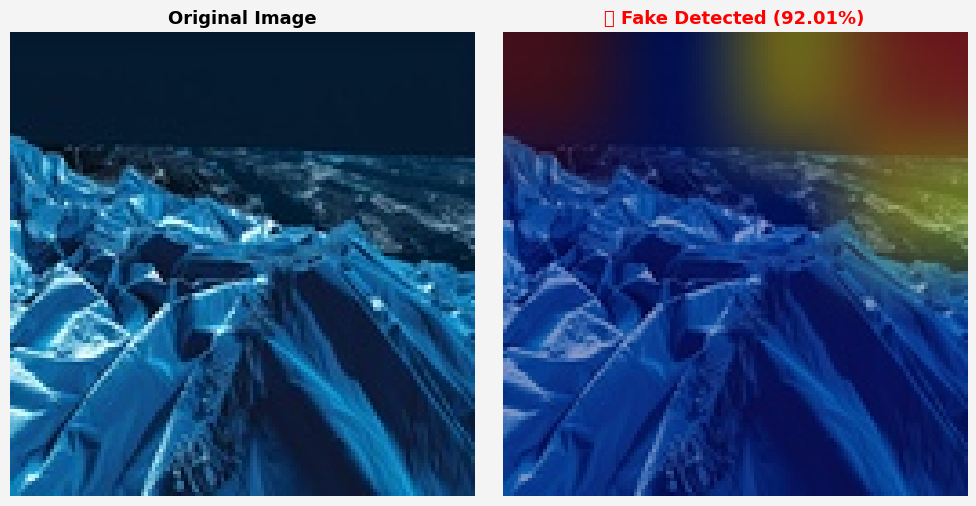

In [17]:
if __name__ == "__main__":
    TEST_IMAGE = "D://Project DeepFake Detection//test//fake//4045.jpg"
    visualize_gradcam(TEST_IMAGE)